In [1]:
!pip install gradientai --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 11.6 MB/s eta 0:00:00


In [2]:
import os
os.environ['GRADIENT_ACCESS_TOKEN'] = "jNHWNUDxYWCDA5FL3eM9LWUkVf4nto2d"
os.environ['GRADIENT_WORKSPACE_ID'] = "fc9472b9-21be-4136-b210-5a9abdb5c169_workspace"

In [3]:
import json
from gradientai import Gradient
import pandas as pd

# Before Fine tunning




In [4]:
from gradientai import Gradient

def main():
  with Gradient() as gradient:
      base_model = gradient.get_base_model(base_model_slug="nous-hermes2")

      new_model_adapter = base_model.create_model_adapter(
          name="test model 3"
      )
      print(f"Created model adapter with id {new_model_adapter.id}")
      sample_query = "### Who is the dean of CCSIT at IAU? \n\n### Response:"
      print(f"Asking: {sample_query}")

      # before fine-tuning
      completion = new_model_adapter.complete(query=sample_query, max_generated_token_count=100).generated_output
      print(f"Generated (before fine-tune): {completion}")


      new_model_adapter.delete()

if __name__ == "__main__":
    main()

Created model adapter with id e52fc26c-18fd-4484-83fc-97894e65d0f0_model_adapter
Asking: ### Who is the dean of CCSIT at IAU? 

### Response:
Generated (before fine-tune):  Dr. Alireza Salehi is the dean of CCSIT at IAU.


# **Read the files with new data set structure**

In [4]:


def convert (input_file):
  output_data = []
  with open(input_file, 'r') as file:
      for line in file:
          item = json.loads(line)
          user_message = item["messages"][1]["content"]
          assistant_message = item["messages"][2]["content"]
          formatted_data = {
              "inputs": f"### Instruction: {user_message}\n\n### Response: {assistant_message}"
          }
          output_data.append(formatted_data)
  return output_data

def saveFile(file_name,output_data):
  # Write the output data to a JSON file
  output_file = file_name

  with open(output_file, 'w') as file:
      json.dump(output_data, file, indent=4)

  print(f"Formatted data has been written to {output_file}")

In [5]:
# Specify the input JSONL file
trin_file = "/content/drive/MyDrive/train_data.jsonl"
valid_file = '/content/drive/MyDrive/validation_data.jsonl'
train_and_valid = []
out_file = 'train_Llama2.jsonl'
#convert train to new strcture
train = convert(trin_file)

valid = convert(valid_file)

train_and_valid = train + valid
saveFile(out_file,train_and_valid)


Formatted data has been written to train_Llama2.jsonl


In [6]:
# Specify the input JSONL file
test_file = "/content/drive/MyDrive/test_data.jsonl"

test = []
out_file = 'test_Llama2.jsonl'
#convert train to new strcture
test = convert(test_file)

saveFile(out_file,test)


Formatted data has been written to test_Llama2.jsonl


In [ ]:
print(len(train))
print(len(valid))
print(len(train) + len(valid))
print(len(train_and_valid))
print(len(test))

178
23
201
201
44


# **Trian Model**

In [7]:

#read training data
file_path = '/content/drive/MyDrive/train_Up_Llama2.jsonl'  # Replace with the actual path to your JSON file

with open(file_path, 'r') as file:
    # Load the JSON data
    data_train = json.load(file)
print(len(data_train))

201


In [8]:


def main():

  with Gradient() as gradient:
      #nous-hermes2 is a fine tuned vesion of Llama-2 13B Nous Hermes 2
      base_model = gradient.get_base_model(base_model_slug="nous-hermes2")

      #make a copy of the base model aims to fine-tuned
      new_model_adapter = base_model.create_model_adapter(
          name="CCSIT_InfoBot"
      )

      # this is where fine-tuning happens
      # num_epochs is the number of times you fine-tune the model
      # more epochs tends to get better results, but you also run the risk of "overfitting"
      # play around with this number to find what works best for you
      num_epochs = 3
      batch_size_limit = 100
      count = 0

      while count < num_epochs:
          print(f"Fine-tuning the model, iteration {count + 1}")

          # Ensure that each iteration uses a batch size within the limit
          for start_idx in range(0, len(data_train), batch_size_limit):
              end_idx = start_idx + batch_size_limit
              batch_data = data_train[start_idx:end_idx]

              # Call the fine_tune method with the current batch
              new_model_adapter.fine_tune(samples=batch_data)

          count += 1


if __name__ == "__main__":
    main()

Fine-tuning the model, iteration 1
Fine-tuning the model, iteration 2
Fine-tuning the model, iteration 3


# **Test the Model**

In [9]:
#test model with one query


def main():
  with Gradient() as gradient:

      #nous-hermes2 is a fine tuned vesion of Llama-2 13B Nous Hermes 2
      base_model = gradient.get_base_model(base_model_slug="nous-hermes2")

      #make a copy of the base model aims to fine-tuned
      new_model_adapter = base_model.create_model_adapter(
          name="CCSIT_InfoBot"
      )
      sample_query = "### Instruction: Who is the dean of CCSIT at IAU?\n\n### Response:"
      # after fine-tuning
      completion = new_model_adapter.complete(query=sample_query, max_generated_token_count=100).generated_output
      print(f"Generated (after fine-tune): {completion}")

#new_model_adapter.delete()
if __name__ == "__main__":
    main()


Generated (after fine-tune):  Dr. Ali R. Akbar is the dean of the College of Computer Science and Information Technology (CCSIT) at Islamic Azad University (IAU).


In [ ]:
#read and restructure the query format and save it in a Data Frame


file_path = '/content/drive/MyDrive/test_Up_Llama2.jsonl'  # Replace with the actual path to your JSON file

with open(file_path, 'r') as file:
    # Load the JSON data
    data_train = json.load(file)
final_df = pd.DataFrame(columns=['instruction', 'response','Generate Response'])
for i in range(len(data_train)):
  l = data_train[i]
  instruction = l['inputs'].split('### Response:')[0].strip() + '\\n\\n ### Response:'
  response = '### Response:' + l['inputs'].split('### Response:')[1].strip()
  temp_df = pd.DataFrame({
    'instruction': [instruction],
    'response': [response],
    'Generate Response' :''
  })

  # Append the temporary DataFrame to the final DataFrame
  final_df = final_df.append(temp_df, ignore_index=True)

In [ ]:
#test model with whole testing set


def main():
  with Gradient() as gradient:

      #nous-hermes2 is a fine tuned vesion of Llama-2 13B Nous Hermes 2
      base_model = gradient.get_base_model(base_model_slug="nous-hermes2")

      #make a copy of the base model aims to fine-tuned
      new_model_adapter = base_model.create_model_adapter(
          name="CCSIT_InfoBot"
      )
      for i in range(len(final_df)):
        sample_query = final_df['instruction'][i]
        # after fine-tuning
        completion = new_model_adapter.complete(query=sample_query, max_generated_token_count=100).generated_output
        print(f"Generated (after fine-tune): {completion}")
        final_df['Generate Response'][i] = completion

#new_model_adapter.delete()
if __name__ == "__main__":
    main()

Generated (after fine-tune):  I'm sorry but I don't have any information about the IAU university. Could you please provide more details or context about the university you are referring to?
Generated (after fine-tune):  The College of Computer Science and Information Technology was established in 2001.
Generated (after fine-tune):  The goals of the College of Engineering at the University of California, Berkeley are to:
1. Provide a world-class engineering education that prepares students for successful careers in industry, academia, and government.
2. Conduct cutting-edge research that advances the field of engineering and has a positive impact on society.
3. Foster an inclusive and diverse community that values and promotes collaboration, innovation, and creativity.
4. Engage
Generated (after fine-tune):  The College's approach to financial sustainability involves a combination of strategic planning, cost management, and revenue generation initiatives. The College's leadership team 

In [ ]:
final_df.head()

,instruction,response,Generate Response
0,### Instruction: What is the student populatio...,### Response:The student population of the uni...,I'm sorry but I don't have any information ab...
1,### Instruction: When was the College of Compu...,### Response:The College was established in 2010.,The College of Computer Science and Informati...
2,### Instruction: What are some of the goals of...,### Response:Goals include offering quality ed...,The goals of the College of Engineering at th...
3,### Instruction: What is the College's approac...,### Response:The College aims to strengthen fi...,The College's approach to financial sustainab...
4,### Instruction: Can you share some examples o...,### Response:Research areas at CCSIT include a...,Certainly! Here are some examples of research...


# Save the first train in csv file

In [ ]:
file_path = 'first_trail_Llama2.csv'
final_df.to_csv(file_path, index=False)

# Read the trined file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/first_trail_Llama2.csv', index_col=0)
df.head()

,response,Generate Response
instruction,,
### Instruction: What is the student population of the IAU university?\n\n ### Response:,### Response:The student population of the uni...,I'm sorry but I don't have any information ab...
### Instruction: When was the College of Computer Science and Information Technology established?\n\n ### Response:,### Response:The College was established in 2010.,The College of Computer Science and Informati...
### Instruction: What are some of the goals of the College?\n\n ### Response:,### Response:Goals include offering quality ed...,The goals of the College of Engineering at th...
### Instruction: What is the College's approach to financial sustainability?\n\n ### Response:,### Response:The College aims to strengthen fi...,The College's approach to financial sustainab...
### Instruction: Can you share some examples of research areas at CCSIT?\n\n ### Response:,### Response:Research areas at CCSIT include a...,Certainly! Here are some examples of research...


In [ ]:
#new data frame for the response coulmn
response = pd.DataFrame()
# Define a regular expression to extract text after "### Response:"
pattern = "### Response:(.+)"

# Apply the regular expression and create a new column with the extracted text
response['Original_Response'] = df['response'].str.extract(pattern)

# Display the DataFrame with the new column
response.head()


,Original_Response
instruction,
### Instruction: What is the student population of the IAU university?\n\n ### Response:,The student population of the university is ov...
### Instruction: When was the College of Computer Science and Information Technology established?\n\n ### Response:,The College was established in 2010.
### Instruction: What are some of the goals of the College?\n\n ### Response:,Goals include offering quality education in th...
### Instruction: What is the College's approach to financial sustainability?\n\n ### Response:,The College aims to strengthen financial self-...
### Instruction: Can you share some examples of research areas at CCSIT?\n\n ### Response:,Research areas at CCSIT include artificial int...


In [ ]:
response=response.reset_index(drop=True)
response.head()

,Original_Response
0,The student population of the university is ov...
1,The College was established in 2010.
2,Goals include offering quality education in th...
3,The College aims to strengthen financial self-...
4,Research areas at CCSIT include artificial int...


## Bleu Score

In [ ]:
import nltk

# Download the NLTK data for calculating BLEU
nltk.download('punkt')
nltk.download('wordnet')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_score(candidate, reference):
    # Convert the candidate and reference sentences into tokenized lists
    candidate_tokens = nltk.word_tokenize(candidate)
    reference_tokens = nltk.word_tokenize(reference)

    # print( candidate_tokens , "\n_____\n" , reference_tokens , "\n*****")

    # Calculate BLEU score using the sentence_bleu function
    smoothing = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothing)


    return bleu_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['BLEU'] = None
for i in range(len(df)):
  df['BLEU'][i] = calculate_bleu_score(df['Generate Response'][i], response['Original_Response'][i])

In [ ]:
#average of BLEU results

avg_BLEU = df['BLEU'].mean()
avg_BLEU

0.006263782541194721

## **ROUGE Score**

In [ ]:
! pip install -r rouge/requirements.txt
! pip install rouge-score

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'rouge/requirements.txt'
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=2e779bf3f6e3d998ef0c5484246a15f9a3bbc80eb0d80501055897e773db8f81
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

#ROUGE-1 measures unigram overlap between the model-generated summary and the reference summary.
df['rouge1_precision'] = None
df['rouge1_recal'] = None
df['rouge1_fmeasure'] = None

#ROUGE-L considers the longest common subsequence (LCS) of words between the model-generated summary and the reference summary.
df['rougeL_precision'] = None
df['rougeL_recal'] = None
df['rougeL_fmeasure'] = None


for i in range(len(df)):
  score = scorer.score(response['Original_Response'][i],df['Generate Response'][i])
  pre , recall , fmeasure  = score['rouge1']
  df['rouge1_precision'][i] = pre
  df['rouge1_recal'][i] = recall
  df['rouge1_fmeasure'][i] = fmeasure

  pre , recall , fmeasure  = score['rougeL']
  df['rougeL_precision'][i] = pre
  df['rougeL_recal'][i] = recall
  df['rougeL_fmeasure'][i] = fmeasure

df.head()


,response,Generate Response,BLEU,rouge1_precision,rouge1_recal,rouge1_fmeasure,rougeL_precision,rougeL_recal,rougeL_fmeasure
instruction,,,,,,,,,
### Instruction: What is the student population of the IAU university?\n\n ### Response:,### Response:The student population of the uni...,I'm sorry but I don't have any information ab...,0.009048,0.103448,0.3,0.153846,0.103448,0.3,0.153846
### Instruction: When was the College of Computer Science and Information Technology established?\n\n ### Response:,### Response:The College was established in 2010.,The College of Computer Science and Informati...,0.018724,0.416667,0.833333,0.555556,0.416667,0.833333,0.555556
### Instruction: What are some of the goals of the College?\n\n ### Response:,### Response:Goals include offering quality ed...,The goals of the College of Engineering at th...,0.005832,0.147059,0.344828,0.206186,0.102941,0.241379,0.14433
### Instruction: What is the College's approach to financial sustainability?\n\n ### Response:,### Response:The College aims to strengthen fi...,The College's approach to financial sustainab...,0.005671,0.090909,0.375,0.146341,0.090909,0.375,0.146341
### Instruction: Can you share some examples of research areas at CCSIT?\n\n ### Response:,### Response:Research areas at CCSIT include a...,Certainly! Here are some examples of research...,0.00408,0.140845,0.588235,0.227273,0.140845,0.588235,0.227273


## **METEOR Score**

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.translate import meteor_score

# Function to tokenize a sentence
def tokenize_sentence(sentence):
    return word_tokenize(sentence.lower())

# Function to calculate METEOR score for a pair of tokenized sentences
def calculate_meteor_score(reference, candidate):
    return meteor_score.single_meteor_score(reference, candidate)

df['METEOR']=None

# Iterate through rows and calculate METEOR scores
for i in range(len(df)):
    # Tokenize reference and candidate sentences
    reference_tokens = tokenize_sentence(response['Original_Response'][i])
    candidate_tokens = tokenize_sentence(df['Generate Response'][i])

    # Calculate METEOR score and assign to 'METEOR' column
    df['METEOR'][i] = calculate_meteor_score(reference_tokens, candidate_tokens)

# Display the updated DataFrame
df.head()

,response,Generate Response,BLEU,rouge1_precision,rouge1_recal,rouge1_fmeasure,rougeL_precision,rougeL_recal,rougeL_fmeasure,METEOR
instruction,,,,,,,,,,
### Instruction: What is the student population of the IAU university?\n\n ### Response:,### Response:The student population of the uni...,I'm sorry but I don't have any information ab...,0.009048,0.103448,0.3,0.153846,0.103448,0.3,0.153846,0.260847
### Instruction: When was the College of Computer Science and Information Technology established?\n\n ### Response:,### Response:The College was established in 2010.,The College of Computer Science and Informati...,0.018724,0.416667,0.833333,0.555556,0.416667,0.833333,0.555556,0.740132
### Instruction: What are some of the goals of the College?\n\n ### Response:,### Response:Goals include offering quality ed...,The goals of the College of Engineering at th...,0.005832,0.147059,0.344828,0.206186,0.102941,0.241379,0.14433,0.260197
### Instruction: What is the College's approach to financial sustainability?\n\n ### Response:,### Response:The College aims to strengthen fi...,The College's approach to financial sustainab...,0.005671,0.090909,0.375,0.146341,0.090909,0.375,0.146341,0.159817
### Instruction: Can you share some examples of research areas at CCSIT?\n\n ### Response:,### Response:Research areas at CCSIT include a...,Certainly! Here are some examples of research...,0.00408,0.140845,0.588235,0.227273,0.140845,0.588235,0.227273,0.337417


In [ ]:
#average of METEOR results
avg_METEOR = df['METEOR'].mean()
avg_METEOR

0.29773359729231097

# **BERT score**

In [ ]:
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
from bert_score import score
import pandas as pd

In [ ]:


# Assuming you have a DataFrame named 'df' with columns 'Original_Response' and 'Generate_Response'
# df = pd.DataFrame(...)

def calculate_bert_score(reference, candidate):
    P, R, F1 = score([reference], [candidate], lang="en", verbose=True)
    return P[0].item(), R[0].item(), F1[0].item() #extracting the scalar value at the first index of the PyTorch tensor P.

# Create new columns for BERT scores
df['BERTScore_P'] = None
df['BERTScore_R'] = None
df['BERTScore_F'] = None

# Iterate through rows and calculate BERT scores
for i in range(len(df)):
    ref_response = response['Original_Response'][i]
    gen_response = df['Generate Response'][i]

    # Calculate BERT scores
    pre, recall, fmeasure = calculate_bert_score(ref_response, gen_response)

    # Assign BERT scores to DataFrame
    df.at[i, 'BERTScore_P'] = pre
    df.at[i, 'BERTScore_R'] = recall
    df.at[i, 'BERTScore_F'] = fmeasure

# Display the updated DataFrame
print(df.head())


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.85 seconds, 1.17 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.66 seconds, 1.51 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.74 seconds, 0.57 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.74 seconds, 0.57 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.92 seconds, 0.52 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.75 seconds, 0.57 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.77 seconds, 0.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.30 seconds, 0.77 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.73 seconds, 0.58 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.58 seconds, 0.39 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.78 seconds, 0.56 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.41 seconds, 0.41 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.82 seconds, 0.55 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.79 seconds, 0.56 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.68 seconds, 0.37 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.88 seconds, 0.53 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.72 seconds, 0.58 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.36 seconds, 0.74 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.61 seconds, 0.62 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.85 seconds, 0.35 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.62 seconds, 0.62 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.04 seconds, 0.49 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.66 seconds, 0.27 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.77 seconds, 0.57 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.48 seconds, 0.67 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.11 seconds, 0.47 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.75 seconds, 0.57 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.52 seconds, 0.40 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.69 seconds, 0.59 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.85 seconds, 0.54 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.60 seconds, 0.38 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.75 seconds, 0.57 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.07 seconds, 0.48 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.92 seconds, 0.52 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.84 seconds, 0.35 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.66 seconds, 0.38 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.82 seconds, 0.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.60 seconds, 0.62 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.70 seconds, 0.59 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.17 seconds, 0.46 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.45 seconds, 0.69 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.04 seconds, 0.49 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.25 seconds, 0.31 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.91 seconds, 0.26 sentences/sec
                                         instruction  \
0  ### Instruction: What is the student populatio...   
1  ### Instruction: When was the College of Compu...   
2  ### Instruction: What are some of the goals of...   
3  ### Instruction: What is the College's approac...   
4  ### Instruction: Can you share some examples o...   

                                            response  \
0  ### Response:The student population of the uni...   
1  ### Response:The College was established in 2010.   
2  ### Response:Goals include offering quality ed...   
3  ### Response:The College aims to strengthen fi...   
4  ### Response:Research areas at CCSIT include a...   

                                   Generate Response      BLEU  \
0   I'm sorry but I don't have any information ab...  0.009048   
1   The College of Computer Science and Informati...  0.018724   
2   The goals of the College of Engineering at th...  0.005832   
3   The College's app

In [ ]:
df.head()

,instruction,response,Generate Response,BLEU,rouge1_precision,rouge1_recal,rouge1_fmeasure,rougeL_precision,rougeL_recal,rougeL_fmeasure,METEOR,BERTScore_P,BERTScore_R,BERTScore_F
0,### Instruction: What is the student populatio...,### Response:The student population of the uni...,I'm sorry but I don't have any information ab...,0.009048,0.103448,0.3,0.153846,0.103448,0.3,0.153846,0.260847,0.868818,0.821675,0.844589
1,### Instruction: When was the College of Compu...,### Response:The College was established in 2010.,The College of Computer Science and Informati...,0.018724,0.416667,0.833333,0.555556,0.416667,0.833333,0.555556,0.740132,0.953365,0.875466,0.912757
2,### Instruction: What are some of the goals of...,### Response:Goals include offering quality ed...,The goals of the College of Engineering at th...,0.005832,0.147059,0.344828,0.206186,0.102941,0.241379,0.14433,0.260197,0.86097,0.851105,0.856009
3,### Instruction: What is the College's approac...,### Response:The College aims to strengthen fi...,The College's approach to financial sustainab...,0.005671,0.090909,0.375,0.146341,0.090909,0.375,0.146341,0.159817,0.890977,0.851472,0.870777
4,### Instruction: Can you share some examples o...,### Response:Research areas at CCSIT include a...,Certainly! Here are some examples of research...,0.00408,0.140845,0.588235,0.227273,0.140845,0.588235,0.227273,0.337417,0.893751,0.851559,0.872145


In [ ]:
df.tail()

,instruction,response,Generate Response,BLEU,rouge1_precision,rouge1_recal,rouge1_fmeasure,rougeL_precision,rougeL_recal,rougeL_fmeasure,METEOR,BERTScore_P,BERTScore_R,BERTScore_F
39,### Instruction: Provide information about kha...,### Response:khalid mohamed hassan aloub is a ...,Khalid Mohamed Hassan Aloub is a Saudi Arabia...,0.006384,0.234375,0.416667,0.3,0.1875,0.333333,0.24,0.282785,0.815772,0.82153,0.818641
40,### Instruction: Tell me about Amal Hadi Alhaj...,### Response:Amal Hadi Alhajri is a Lecturer i...,Amal Hadi Alhajri is a Bahraini professional ...,0.008372,0.230769,0.26087,0.244898,0.211538,0.23913,0.22449,0.176282,0.820649,0.821453,0.821051
41,### Instruction: Tell me about Gomathi Krishna...,### Response:Gomathi Krishna is a Lecturer in ...,Gomathi Krishna is an Indian middle-distance ...,0.006485,0.186441,0.268293,0.22,0.135593,0.195122,0.16,0.240738,0.806041,0.81463,0.810313
42,### Instruction: Tell me about Mamoun Masoud I...,### Response:Mamoun Masoud Ibrahim Abdulqader ...,Mamoun Masoud Ibrahim Abdulqader is a Syrian ...,0.006704,0.2,0.325,0.247619,0.153846,0.25,0.190476,0.227366,0.821312,0.825139,0.823221
43,### Instruction: What is the vision of the Alu...,### Response:The vision of the center is to ta...,The vision of the Alumni and Career Developme...,0.00803,0.341463,0.518519,0.411765,0.292683,0.444444,0.352941,0.377027,0.918959,0.900269,0.909518


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   instruction        44 non-null     object
 1   response           44 non-null     object
 2   Generate Response  44 non-null     object
 3   BLEU               44 non-null     object
 4   rouge1_precision   44 non-null     object
 5   rouge1_recal       44 non-null     object
 6   rouge1_fmeasure    44 non-null     object
 7   rougeL_precision   44 non-null     object
 8   rougeL_recal       44 non-null     object
 9   rougeL_fmeasure    44 non-null     object
 10  METEOR             44 non-null     object
 11  BERTScore_P        44 non-null     object
 12  BERTScore_R        44 non-null     object
 13  BERTScore_F        44 non-null     object
dtypes: object(14)
memory usage: 4.9+ KB


In [ ]:
file_path = 'evaluation_Llama2_FirstTrail.csv'
df.to_csv(file_path, index=False)

In [8]:
df = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_FirstTrail.csv')
df.head()

,instruction,response,Generate Response,BLEU,rouge1_precision,rouge1_recal,rouge1_fmeasure,rougeL_precision,rougeL_recal,rougeL_fmeasure,METEOR,BERTScore_P,BERTScore_R,BERTScore_F
0,### Instruction: What is the student populatio...,### Response:The student population of the uni...,I'm sorry but I don't have any information ab...,0.009048,0.103448,0.300000,0.153846,0.103448,0.300000,0.153846,0.260847,0.868818,0.821675,0.844589
1,### Instruction: When was the College of Compu...,### Response:The College was established in 2010.,The College of Computer Science and Informati...,0.018724,0.416667,0.833333,0.555556,0.416667,0.833333,0.555556,0.740132,0.953365,0.875466,0.912757
2,### Instruction: What are some of the goals of...,### Response:Goals include offering quality ed...,The goals of the College of Engineering at th...,0.005832,0.147059,0.344828,0.206186,0.102941,0.241379,0.144330,0.260197,0.860970,0.851105,0.856009
3,### Instruction: What is the College's approac...,### Response:The College aims to strengthen fi...,The College's approach to financial sustainab...,0.005671,0.090909,0.375000,0.146341,0.090909,0.375000,0.146341,0.159817,0.890977,0.851472,0.870777
4,### Instruction: Can you share some examples o...,### Response:Research areas at CCSIT include a...,Certainly! Here are some examples of research...,0.004080,0.140845,0.588235,0.227273,0.140845,0.588235,0.227273,0.337417,0.893751,0.851559,0.872145


In [9]:
import pandas as pd


# List of evaluation measures
evaluation_measures = ['BLEU', 'rouge1_precision', 'rouge1_recal', 'rouge1_fmeasure',
                        'rougeL_precision', 'rougeL_recal', 'rougeL_fmeasure',
                        'METEOR', 'BERTScore_P', 'BERTScore_R', 'BERTScore_F']

# Create a new DataFrame with relevant columns
df_summary = df[evaluation_measures].describe().transpose()

# Extract the 'mean' column
df_mean = df_summary[['mean']]

# Display the mean values
print(df_mean)


                      mean
BLEU              0.006264
rouge1_precision  0.266044
rouge1_recal      0.457491
rouge1_fmeasure   0.322675
rougeL_precision  0.204806
rougeL_recal      0.365510
rougeL_fmeasure   0.251199
METEOR            0.297734
BERTScore_P       0.871628
BERTScore_R       0.860773
BERTScore_F       0.866013


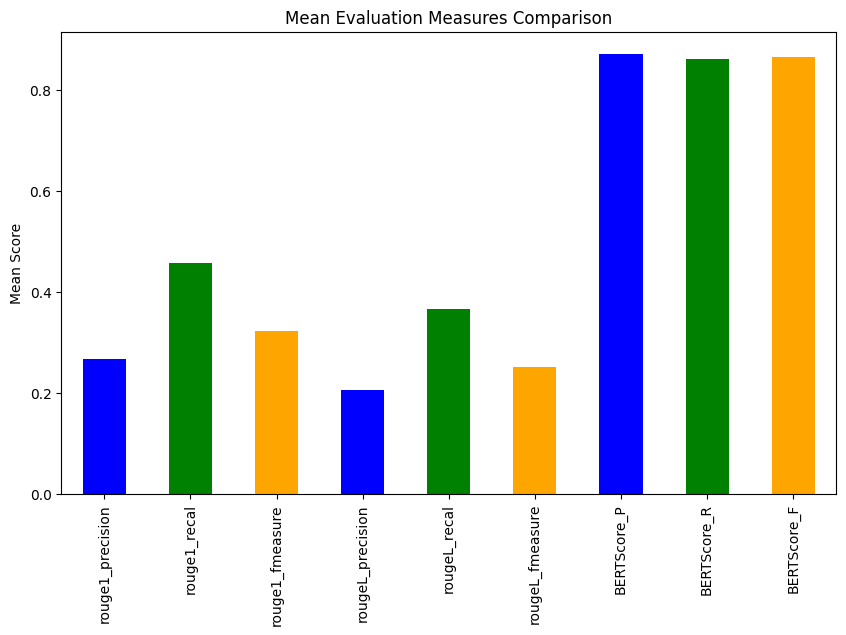

In [10]:
import matplotlib.pyplot as plt
import pandas as pd


# List of evaluation measures
evaluation_measures = ['rouge1_precision', 'rouge1_recal', 'rouge1_fmeasure',
                       'rougeL_precision', 'rougeL_recal', 'rougeL_fmeasure',
                       'BERTScore_P', 'BERTScore_R', 'BERTScore_F']

# Create a new DataFrame with relevant columns
df_means = df[evaluation_measures].mean()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df_means.plot(kind='bar', ax=ax, color=['blue', 'green', 'orange'])
ax.set_ylabel("Mean Score")
ax.set_title("Mean Evaluation Measures Comparison")

plt.show()


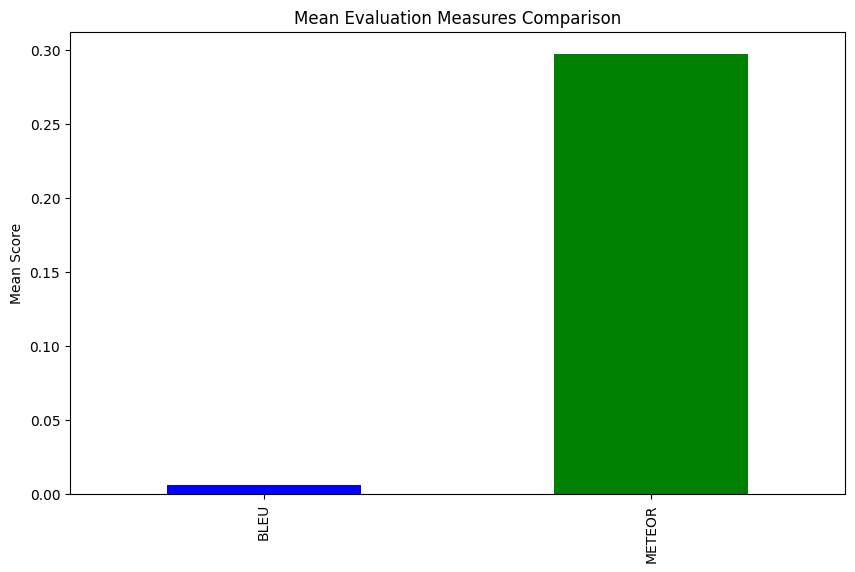

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# List of evaluation measures
evaluation_measures = ['BLEU','METEOR']

# Create a new DataFrame with relevant columns
df_means = df[evaluation_measures].mean()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df_means.plot(kind='bar', ax=ax, color=['blue', 'green'])
ax.set_ylabel("Mean Score")
ax.set_title("Mean Evaluation Measures Comparison")

plt.show()


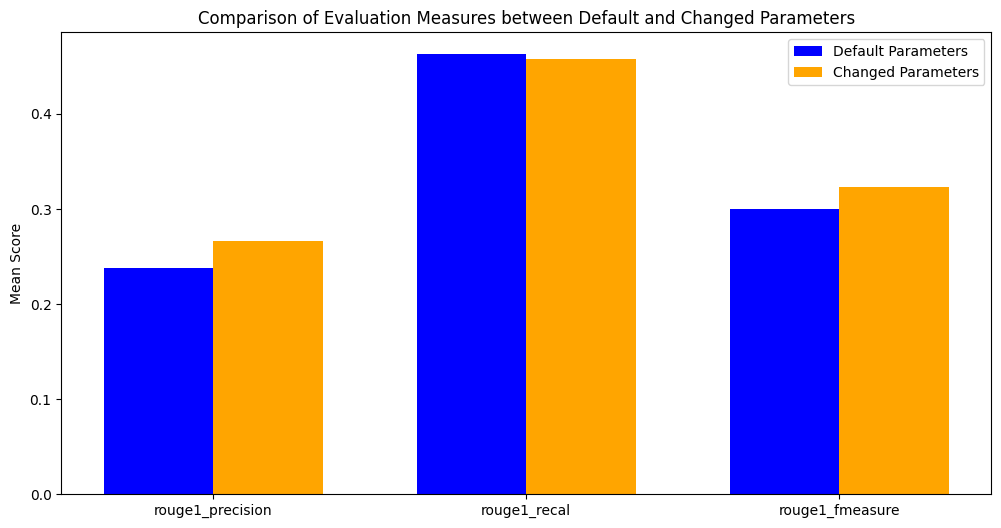

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_parameter.csv')
df2 = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_FirstTrail.csv')

# List of evaluation measures
evaluation_measures = ['rouge1_precision', 'rouge1_recal', 'rouge1_fmeasure']

# Calculate mean values for each dataset
df_means = df[evaluation_measures].mean()
df2_means = df2[evaluation_measures].mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions = range(len(evaluation_measures))

bar1 = ax.bar(bar_positions, df_means, bar_width, label='Default Parameters', color='blue')
bar2 = ax.bar([pos + bar_width for pos in bar_positions], df2_means, bar_width, label='Changed Parameters', color='orange')

ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(evaluation_measures)
ax.set_ylabel("Mean Score")
ax.set_title("Comparison of Evaluation Measures between Default and Changed Parameters")
plt.legend()

plt.show()


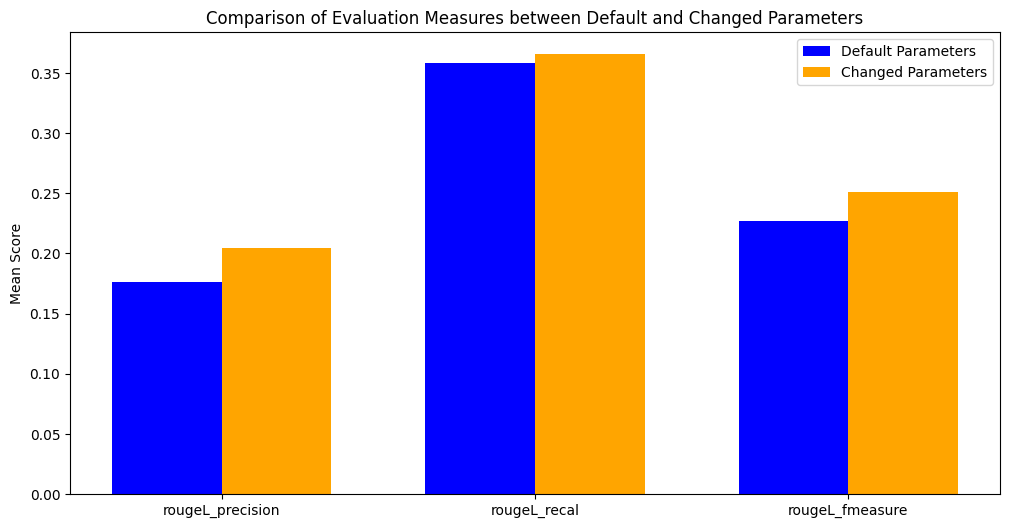

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_parameter.csv')
df2 = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_FirstTrail.csv')

# List of evaluation measures
evaluation_measures = ['rougeL_precision', 'rougeL_recal', 'rougeL_fmeasure']

# Calculate mean values for each dataset
df_means = df[evaluation_measures].mean()
df2_means = df2[evaluation_measures].mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions = range(len(evaluation_measures))

bar1 = ax.bar(bar_positions, df_means, bar_width, label='Default Parameters', color='blue')
bar2 = ax.bar([pos + bar_width for pos in bar_positions], df2_means, bar_width, label='Changed Parameters', color='orange')

ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(evaluation_measures)
ax.set_ylabel("Mean Score")
ax.set_title("Comparison of Evaluation Measures between Default and Changed Parameters")
plt.legend()

plt.show()


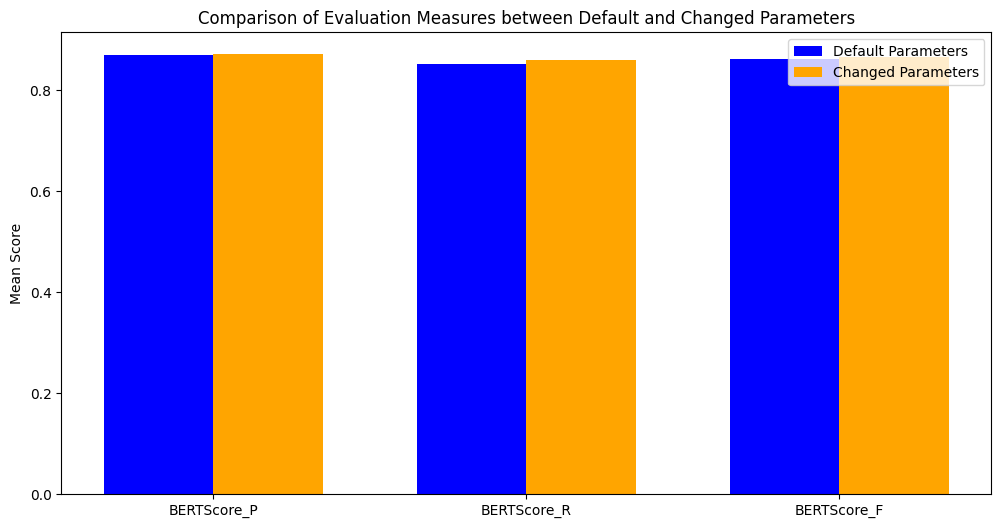

In [17]:

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_parameter.csv')
df2 = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_FirstTrail.csv')

# List of evaluation measures
evaluation_measures = ['BERTScore_P', 'BERTScore_R', 'BERTScore_F']

# Calculate mean values for each dataset
df_means = df[evaluation_measures].mean()
df2_means = df2[evaluation_measures].mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions = range(len(evaluation_measures))

bar1 = ax.bar(bar_positions, df_means, bar_width, label='Default Parameters', color='blue')
bar2 = ax.bar([pos + bar_width for pos in bar_positions], df2_means, bar_width, label='Changed Parameters', color='orange')

ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(evaluation_measures)
ax.set_ylabel("Mean Score")
ax.set_title("Comparison of Evaluation Measures between Default and Changed Parameters")
plt.legend()

plt.show()


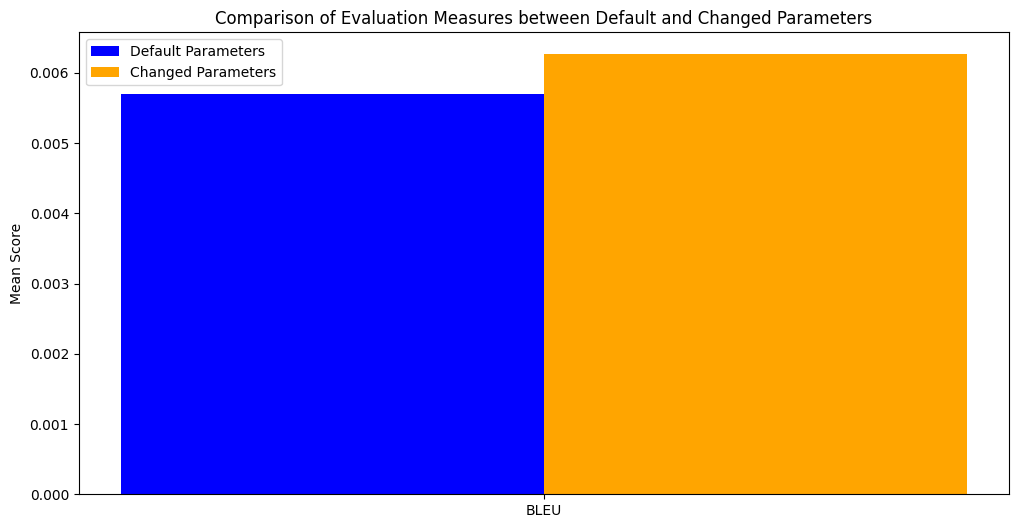

In [18]:

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_parameter.csv')
df2 = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_FirstTrail.csv')

# List of evaluation measures
evaluation_measures = ['BLEU']

# Calculate mean values for each dataset
df_means = df[evaluation_measures].mean()
df2_means = df2[evaluation_measures].mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions = range(len(evaluation_measures))

bar1 = ax.bar(bar_positions, df_means, bar_width, label='Default Parameters', color='blue')
bar2 = ax.bar([pos + bar_width for pos in bar_positions], df2_means, bar_width, label='Changed Parameters', color='orange')

ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(evaluation_measures)
ax.set_ylabel("Mean Score")
ax.set_title("Comparison of Evaluation Measures between Default and Changed Parameters")
plt.legend()

plt.show()


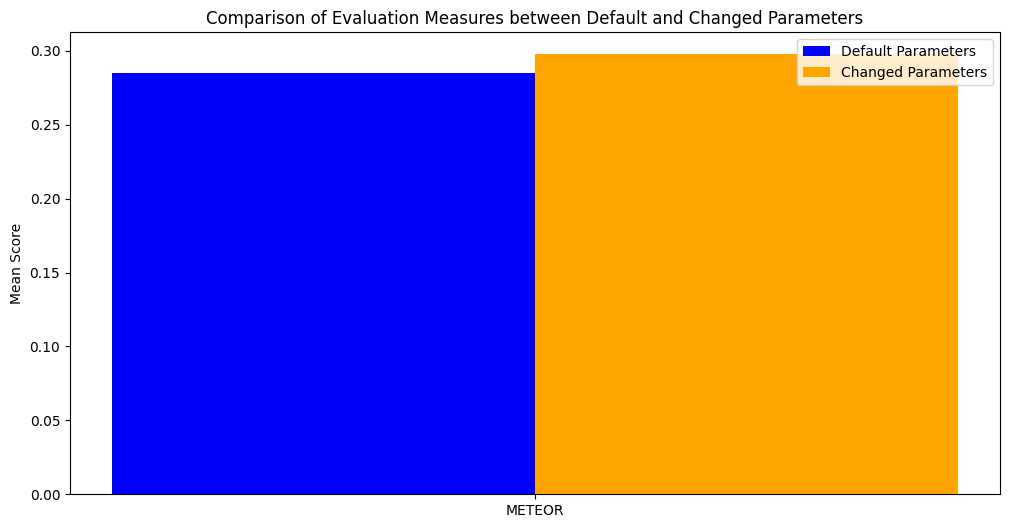

In [19]:

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_parameter.csv')
df2 = pd.read_csv('/content/drive/MyDrive/evaluation_Llama2_FirstTrail.csv')

# List of evaluation measures
evaluation_measures = ['METEOR']

# Calculate mean values for each dataset
df_means = df[evaluation_measures].mean()
df2_means = df2[evaluation_measures].mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions = range(len(evaluation_measures))

bar1 = ax.bar(bar_positions, df_means, bar_width, label='Default Parameters', color='blue')
bar2 = ax.bar([pos + bar_width for pos in bar_positions], df2_means, bar_width, label='Changed Parameters', color='orange')

ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(evaluation_measures)
ax.set_ylabel("Mean Score")
ax.set_title("Comparison of Evaluation Measures between Default and Changed Parameters")
plt.legend()

plt.show()
